<a href="https://colab.research.google.com/github/ebrahimpichka/portfolio-opt/blob/main/portfolio_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization

In general, portfolio optimization is the process of creating a portfolio of assets, for which your investment has the maximum return and minimum risk.
### Modern Portfolio Theory
**Modern Portfolio Theory**, or also known as mean-variance analysis is a mathematical process which allows the user to maximize returns for a given risk level. Or in other terms, minmize risk for a given return level.

It was introduced in a 1952 doctoral thesis by Harry Markowitz. It assumes that an investor wants to maximize a portfolio's expected return contingent on any given amount of risk. For portfolios that meet this criterion, known as efficient portfolios, achieving a higher expected return requires taking on more risk, so investors are faced with a trade-off between risk and expected return.

---


In portfolio theory, the riskiness of an asset is often measured by the ***variance*** (or standard deviation) of its returns. Variance is an important indicator of how volatile this investment will be (how returns can fluctuate). Risk-averse investors do not want their wealth to fluctuate wildly.


a great source for understanding terminology, and calculations:
[Modern Portfolio Theory](https://www.quantconnect.com/tutorials/introduction-to-financial-python/modern-portfolio-theory)


We now try to find a portfolio w=(w1,...,wn) that minimizes risk and maximizes return for a particular set of assets.

In [1]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas_datareader import data as web
from datetime import datetime
import scipy.optimize as opt

In [3]:
plt.style.use('ggplot')

fetching historical price data for list of Stock symbols:

In [4]:
symbols = ['AAPL','GOOG','AMZN','FB']
# symbols = ['APA','BKR','COG','CVX', 'COP', 'DVN', 'FANG', 'HES', 'ALL']
# symbols = ['ATVI','GOOG','FB', 'FOXA', 'LUMN', 'NWSA', 'NWS','TWTR','AMZN']

start_date = datetime(2015,1,1)
end_date = datetime.now()
SOURCE = 'yahoo'


data = web.DataReader(name=symbols,
                    data_source=SOURCE,
                    start=start_date,
                    end=end_date
                    )

In [5]:
data.head(3)

Attributes  Adj Close                          ...     Volume                       
Symbols          AAPL        GOOG        AMZN  ...       GOOG       AMZN          FB
Date                                           ...                                  
2015-01-02  24.782110  523.373108  308.519989  ...  1447563.0  2783200.0  18177500.0
2015-01-05  24.083958  512.463013  302.190002  ...  2059840.0  2774200.0  26452200.0
2015-01-06  24.086227  500.585632  295.290009  ...  2899940.0  3519000.0  27399300.0

[3 rows x 24 columns]

In [6]:
adj_close = data['Adj Close']
volume = data['Volume']

utility functions for calculating portfolio returns, variances, covariance matrix, sharpe ratio etc.

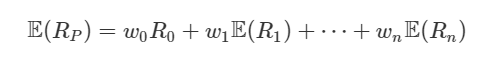

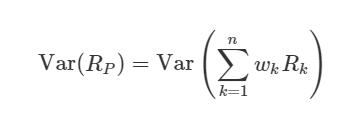

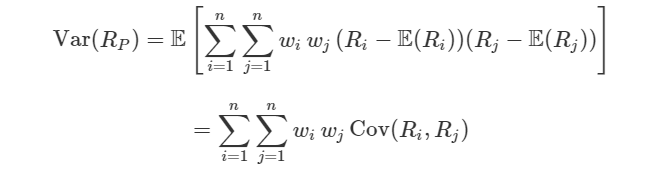

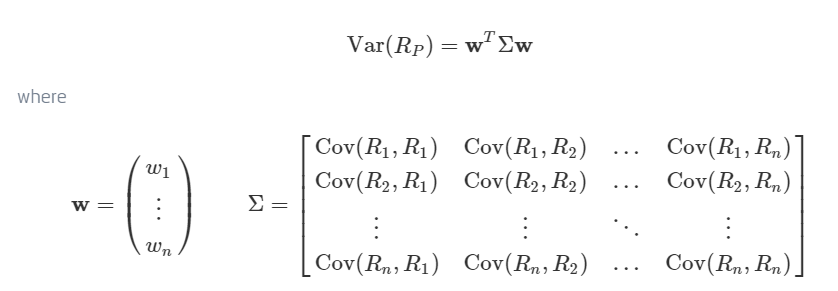

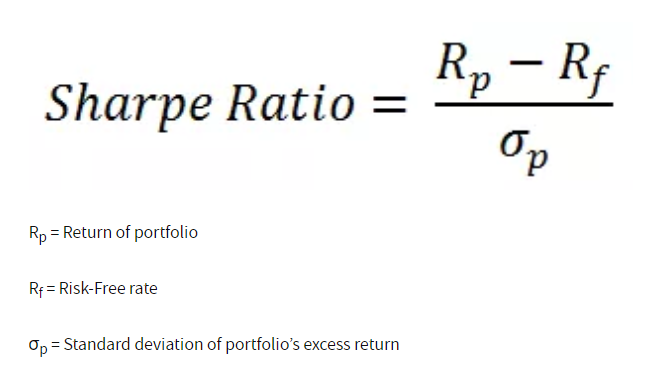

In [7]:
# defining utility functions

def calc_returns(price_data, resample=None, ret_type="arithmatic"):
    """
    Parameters
        price_data: price timeseries pd.DataFrame object.
        resample:   DateOffset, Timedelta or str. `None` for not resampling. Default: None
                    More on Dateoffsets : https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        ret_type:   return calculation type. \"arithmatic\" or \"log\"

    Returns:
        returns timeseries pd.DataFrame object
    """
    if ret_type=="arithmatic":
        ret = price_data.pct_change().dropna()
    elif ret_type=="log":
        ret = np.log(price_data/price_data.shift()).dropna()
    else:
        raise ValueError("ret_type: return calculation type is not valid. use \"arithmatic\" or \"log\"")

    if resample != None:
        if ret_type=="arithmatic":
            ret = ret.resample(resample).apply(lambda df: (df+1).cumprod(axis=0).iloc[-1]) - 1
        elif ret_type=="log":
            ret = ret.resample(resample).apply(lambda df: df.sum(axis=0))
    return(ret)
        

def calc_returns_stats(returns):
    """
    Parameters
        returns: returns timeseries pd.DataFrame object

    Returns:
        mean_returns: Avereage of returns
        cov_matrix: returns Covariance matrix
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return(mean_returns, cov_matrix)

def portfolio(weights, mean_returns, cov_matrix):

    portfolio_return = np.dot(weights.reshape(1,-1), mean_returns.values.reshape(-1,1))
    portfolio_var = np.dot(np.dot(weights.reshape(1,-1), cov_matrix.values), weights.reshape(-1,1))
    portfolio_std = np.sqrt(portfolio_var)

    return(np.squeeze(portfolio_return),np.squeeze(portfolio_var),np.squeeze(portfolio_std))

In [8]:
monthly_ret_arith = calc_returns(adj_close, resample='BM', ret_type="arithmatic")
monthly_ret_arith.head()

Symbols,AAPL,GOOG,AMZN,FB
Date,,,,
2015-01-30,0.071618,0.018502,0.149131,-0.032377
2015-02-27,0.100776,0.044676,0.072293,0.040311
2015-03-31,-0.031372,-0.018625,-0.021202,0.041155
2015-04-30,0.005786,-0.016760,0.133512,-0.041961
2015-05-29,0.045339,-0.009733,0.017663,0.005332


In [9]:
monthly_ret_log = calc_returns(adj_close, resample='BM', ret_type="log")
monthly_ret_log.head()

Symbols,AAPL,GOOG,AMZN,FB
Date,,,,
2015-01-30,0.069170,0.018333,0.139006,-0.032913
2015-02-27,0.096016,0.043706,0.069799,0.039520
2015-03-31,-0.031874,-0.018800,-0.021430,0.040331
2015-04-30,0.005770,-0.016902,0.125321,-0.042866
2015-05-29,0.044341,-0.009781,0.017509,0.005318


## calculating the returns of an eqaully-weighted portfolio

In [10]:
equal_weights = np.array([1/len(symbols) for _ in range(len(symbols))])

mean_returns, cov_matrix = calc_returns_stats(monthly_ret_arith)
portfolio_return, portfolio_var, portfolio_std = portfolio(equal_weights, mean_returns, cov_matrix)


In [11]:
print("monthly portfolio return:\t%", round(100*portfolio_return.item(),2))
print("\nmonthly portfolio variance:\t%",round(100*portfolio_var.item(),2))
print("\nmean monthly returns of individual assets:\n",mean_returns)
print("\ncovariance matrix of assets returns:\n",cov_matrix)

monthly portfolio return:	% 2.59

monthly portfolio variance:	% 0.37

mean monthly returns of individual assets:
 Symbols
AAPL    0.025845
GOOG    0.022926
AMZN    0.032971
FB      0.021823
dtype: float64

covariance matrix of assets returns:
 Symbols      AAPL      GOOG      AMZN        FB
Symbols                                        
AAPL     0.006714  0.002308  0.003252  0.003079
GOOG     0.002308  0.004069  0.003105  0.002768
AMZN     0.003252  0.003105  0.007034  0.003408
FB       0.003079  0.002768  0.003408  0.005701


# Monte Carlo Simuation
## Long-only fully invested porfolios

In [12]:
num_iter = 500000

porfolio_var_list = []
porfolio_ret_list = []
w_list =[]

max_sharpe = 0
max_sharpe_var = None
max_sharpe_ret = None
max_sharpe_w = None

daily_ret = calc_returns(adj_close, resample=None, ret_type="log")
mean_returns, cov_matrix = calc_returns_stats(daily_ret)

for i in range(1,num_iter+1):
    rand_weights = np.random.random(len(symbols))
    rand_weights = rand_weights/np.sum(rand_weights)

    porfolio_ret, porfolio_var, portfolio_std = portfolio(rand_weights, mean_returns, cov_matrix)

    # Anuualizing
    porfolio_ret = porfolio_ret * 252
    porfolio_var = porfolio_var * 252
    portfolio_std = portfolio_std * (252**0.5)

    sharpe = (porfolio_ret/(porfolio_var**0.5)).item()
    if sharpe > max_sharpe:
        max_sharpe = sharpe
        max_sharpe_var = porfolio_var.item()
        max_sharpe_ret = porfolio_ret.item()
        max_sharpe_w = rand_weights

    porfolio_var_list.append(porfolio_var)
    porfolio_ret_list.append(porfolio_ret)
    w_list.append(rand_weights)
    if ((i/num_iter)*100)%10 == 0:
        print(f'%{round((i/num_iter)*100)}...',end='')

%10...%20...%30...%40...%50...%60...%70...%80...%90...%100...

In [13]:
stat = np.hstack([np.array(porfolio_ret_list).reshape(-1,1),
                 np.array(porfolio_var_list).reshape(-1,1),
                 (np.array(porfolio_ret_list)/np.sqrt(np.array(porfolio_var_list))).reshape(-1,1)]
                 )
stat=pd.DataFrame(stat, columns=['Return','Variance','Sharpe ratio'])
stat.head(3)

,Return,Variance,Sharpe ratio
0,0.259459,0.062481,1.037993
1,0.260751,0.062186,1.045633
2,0.269541,0.062280,1.080063


In [14]:
# minimum risk porfolio

min_vol = stat[stat['Variance'] == stat['Variance'].min()]
min_vol_index = min_vol.index.item()
min_vol_weights = w_list[min_vol_index]
print("Portfolio with minimum volatility:\n")
print(f"Annual Sharpe Ratio: {round(stat['Sharpe ratio'][min_vol_index],2)} | Annual Return: % {round(stat['Return'][min_vol_index]*100,2)} | Annual Volatility: % {round(stat['Variance'][min_vol_index]*100,2)}\n")
for index,symbol in enumerate(symbols):
    print(f'{symbol}:\t% {round(min_vol_weights[index]*100,2)}')

Portfolio with minimum volatility:

Annual Sharpe Ratio: 1.12 | Annual Return: % 27.39 | Annual Volatility: % 5.93

AAPL:	% 28.81
GOOG:	% 44.1
AMZN:	% 19.2
FB:	% 7.89


In [15]:
# maximum sharpe ratio porfolio

print("Portfolio with maximum sharpe ratio:\n")
print(f"Annual Sharpe Ratio: {round(max_sharpe,2)} | Annual Return: % {round(max_sharpe_ret*100,2)} | Annual Volatility: % {round(max_sharpe_var*100,2)}\n")
for index,symbol in enumerate(symbols):
    print(f'{symbol}:\t% {round(max_sharpe_w[index]*100,2)}')

Portfolio with maximum sharpe ratio:

Annual Sharpe Ratio: 1.22 | Annual Return: % 31.83 | Annual Volatility: % 6.85

AAPL:	% 24.77
GOOG:	% 13.31
AMZN:	% 61.81
FB:	% 0.11


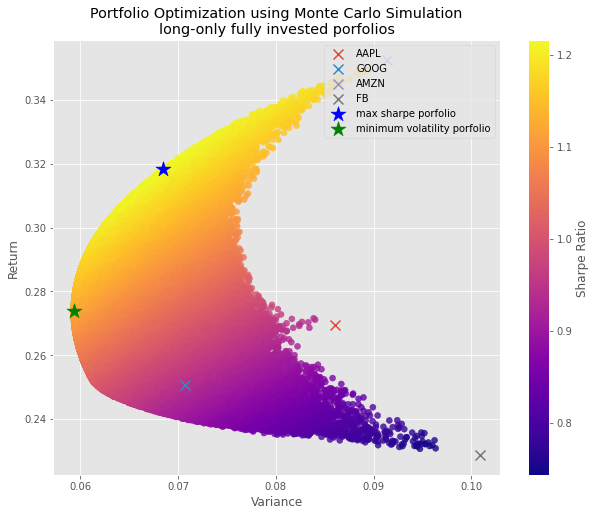

In [16]:
#plotting the portfolios

daily_ret_var = daily_ret.var()
plt.figure(figsize=(10,8))
plt.scatter(porfolio_var_list,porfolio_ret_list,c=stat['Sharpe ratio'], alpha=0.8, cmap='plasma')
for sym in symbols:
    plt.scatter(daily_ret_var.loc[sym]*252, mean_returns.loc[sym]*252, marker='x', s=100, label=sym)

plt.scatter([max_sharpe_var], [max_sharpe_ret], marker='*', s=250, label='max sharpe porfolio', c='blue')
plt.scatter(min_vol['Variance'].values, min_vol['Return'].values, marker='*', s=250, label='minimum volatility porfolio', c='green')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Portfolio Optimization using Monte Carlo Simulation\nlong-only fully invested porfolios')
plt.legend(loc='upper right')

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=stat['Sharpe ratio'].min(), vmax=stat['Sharpe ratio'].max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),label='Sharpe Ratio',);

# Optimization using scipy optimize module (Sequential Least Squares Programming)





In [17]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_var, portfolio_std = portfolio(weights, mean_returns, cov_matrix)
    sr = ((portfolio_return - risk_free_rate)/portfolio_std) * (252**0.5) # annualized
    return(-sr)

def portfolio_variance(weights, mean_returns, cov_matrix):
    portfolio_return, portfolio_var, portfolio_std = portfolio(weights, mean_returns, cov_matrix)
    return(portfolio_var*252)

In [18]:
daily_ret = calc_returns(adj_close, resample=None, ret_type="log")
mean_returns, cov_matrix = calc_returns_stats(daily_ret)

In [19]:
def optimize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0, w_bounds=(0,1)):
    "This function finds the portfolio weights which minimize the negative sharpe ratio"

    init_guess = np.array([1/len(mean_returns) for _ in range(len(mean_returns))])
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = opt.minimize(fun=neg_sharpe_ratio,
                          x0=init_guess,
                          args=args,
                          method='SLSQP',
                          bounds=tuple(w_bounds for _ in range(len(mean_returns))),
                          constraints=constraints,
                          )
    
    if result['success']:
        print(result['message'])
        opt_sharpe = - result['fun']
        opt_weights = result['x']
        opt_return, opt_variance, opt_std = portfolio(opt_weights, mean_returns, cov_matrix)
        return(opt_sharpe, opt_weights, opt_return.item()*252, opt_variance.item()*252, opt_std.item()*(252**0.5))
    else:
        print("Optimization operation was not succesfull!")
        print(result['message'])
        return(None)
    

In [20]:
opt_sharpe, opt_weights, opt_return, opt_variance, opt_std = optimize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0, w_bounds=(0,1))

Optimization terminated successfully.


In [21]:
# maximum sharpe ratio porfolio
print("Portfolio with maximum sharpe ratio:\n")
print(f"Annual Sharpe Ratio: {round(opt_sharpe,2)} | Annual Return: % {round(opt_return*100,2)} | Annual Volatility: % {round(opt_variance*100,2)}\n")
for index,symbol in enumerate(symbols):
    print(f'{symbol}:\t% {round(opt_weights[index]*100,2)}')

Portfolio with maximum sharpe ratio:

Annual Sharpe Ratio: 1.22 | Annual Return: % 31.78 | Annual Volatility: % 6.83

AAPL:	% 23.36
GOOG:	% 15.06
AMZN:	% 61.58
FB:	% 0.0


In [22]:
def minimize_portfolio_variance(mean_returns, cov_matrix, w_bounds=(0,1)):
    "This function finds the portfolio weights which minimize the portfolio volatility(variance)"

    init_guess = np.array([1/len(mean_returns) for _ in range(len(mean_returns))])
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = opt.minimize(fun=portfolio_variance,
                          x0=init_guess,
                          args=args,
                          method='SLSQP',
                          bounds=tuple(w_bounds for _ in range(len(mean_returns))),
                          constraints=constraints,
                          )
    
    if result['success']:
        print(result['message'])
        min_var = result['fun']
        min_var_weights = result['x']
        min_var_return, min_var_variance, min_var_std = portfolio(min_var_weights, mean_returns, cov_matrix)
        min_var_sharpe = (min_var_return/min_var_std)*(252**0.5)
        return(min_var_sharpe, min_var_weights, min_var_return.item()*252, min_var_variance.item()*252, min_var_std.item()*(252**0.5))
    else:
        print("Optimization operation was not succesfull!")
        print(result['message'])
        return(None)

In [23]:
min_var_sharpe, min_var_weights, min_var_return, min_var_variance, min_var_std = minimize_portfolio_variance(mean_returns, cov_matrix, w_bounds=(0,1))

Optimization terminated successfully.


In [24]:
# minimum volatility porfolio
print("Portfolio with maximum sharpe ratio:\n")
print(f"Annual Sharpe Ratio: {round(min_var_sharpe,3)} | Annual Return: % {round(min_var_return*100,2)} | Annual Volatility: % {round(min_var_variance*100,3)}\n")
for index,symbol in enumerate(symbols):
    print(f'{symbol}:\t% {round(min_var_weights[index]*100,2)}')

Portfolio with maximum sharpe ratio:

Annual Sharpe Ratio: 1.123 | Annual Return: % 27.37 | Annual Volatility: % 5.935

AAPL:	% 28.49
GOOG:	% 44.34
AMZN:	% 19.08
FB:	% 8.08


## Minimum Variacne portfolio for a any target level of return



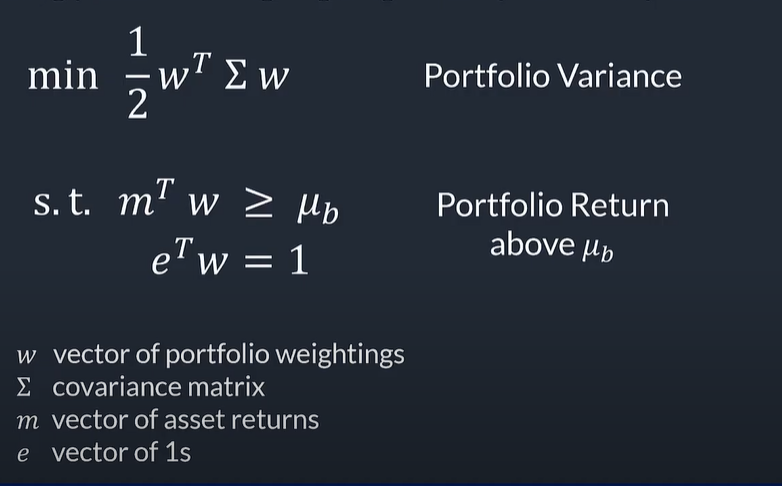

In [25]:
def calc_portfolio_return(weights, mean_returns, cov_matrix):
    portfolio_return, portfolio_var, portfolio_std = portfolio(weights, mean_returns, cov_matrix)
    return(portfolio_return.item()*252)

def efficient_portfolio(mean_returns, cov_matrix, target_return, w_bounds=(0,1)):
    """retuens the portfolio weights with minimum variance for a specific level of expected portfolio return"""    

    init_guess = np.array([1/len(mean_returns) for _ in range(len(mean_returns))])
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                   {'type': 'eq', 'fun': lambda x: 252*np.squeeze(np.dot(x.reshape(1,-1),mean_returns.values.reshape(-1,1))) - target_return})
    result = opt.minimize(fun=portfolio_variance,
                          x0=init_guess,
                          args=args,
                          method='SLSQP',
                          bounds=tuple(w_bounds for _ in range(len(mean_returns))),
                          constraints=constraints,
                          )
    if not result['success']:
        print(result['message'])
    efficient_variance = result['fun']
    efficient_weights = result['x']
    efficient_return, _ , efficient_std = portfolio(efficient_weights, mean_returns, cov_matrix)
    efficient_sahrpe = (efficient_return/efficient_return)*(252**0.5)
    return(efficient_sahrpe, efficient_weights, efficient_return.item()*252, efficient_variance, efficient_std.item()*(252**0.5))

In [26]:
expected_return = 0.3
efficient_sharpe, efficient_weights, efficient_return, efficient_variance, efficient_std = efficient_portfolio(mean_returns,
                                                                                                                cov_matrix,
                                                                                                                target_return=expected_return,
                                                                                                                w_bounds=(0,1))

In [27]:
# efficient porfolio
print("Efficient portfolio for 30% return level:\n")
print(f"Annual Sharpe Ratio: {round(efficient_sharpe ,3)} | Annual Return: % {round(efficient_return*100,2)} | Annual Volatility: % {round(efficient_variance*100,3)}\n")
for index,symbol in enumerate(symbols):
    print(f'{symbol}:\t% {round(efficient_weights[index]*100,2)}')

Efficient portfolio for 30% return level:

Annual Sharpe Ratio: 15.875 | Annual Return: % 30.0 | Annual Volatility: % 6.231

AAPL:	% 26.57
GOOG:	% 29.9
AMZN:	% 43.53
FB:	% 0.0


## Efficient Frontier

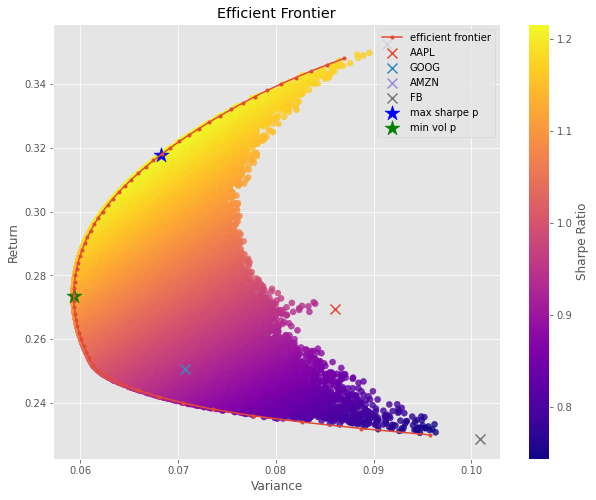

In [29]:

#plotting the Efficient Frontier

daily_ret_var = daily_ret.var()
plt.figure(figsize=(10,8))

target_rets = np.arange(0.23,0.35,0.002)
efficient_vars = np.array([efficient_portfolio(mean_returns,cov_matrix,target_return=x ,w_bounds=(0,1))[3] for x in target_rets])
plt.plot(efficient_vars,target_rets,marker='.',label="efficient frontier")

plt.scatter(porfolio_var_list,porfolio_ret_list,c=stat['Sharpe ratio'], alpha=0.8, cmap='plasma')
for sym in symbols:
    plt.scatter(daily_ret_var.loc[sym]*252, mean_returns.loc[sym]*252, marker='x', s=100, label=sym)

plt.scatter([opt_variance], [opt_return], marker='*', s=250, label='max sharpe p', c='blue')
plt.scatter(min_var_variance, min_var_return, marker='*', s=250, label='min vol p', c='green')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend(loc='upper right')

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=stat['Sharpe ratio'].min(), vmax=stat['Sharpe ratio'].max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),label='Sharpe Ratio',);